In [1]:
# !git clone -b update-gluonts https://github.com/time-series-foundation-models/lag-llama/
# !pip install -U -r ./lag-llama/requirements.txt 
# !huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ./lag-llama
# !pip install gluonts==0.14.4

In [2]:
import os 
import sys

In [3]:
sys.path.append("./time-series-models/lag-llama")
sys.path.append("./lag-llama")

In [4]:
from itertools import islice

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

import yfinance as yf
import numpy as np
from pprint import pprint 
from datetime import date

from sklearn.metrics import mean_squared_error, r2_score


In [5]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

In [6]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    # Use this if we have a GPU:
    # ckpt = torch.load("./time-series-models/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    
    # Assume we use CPU:
    ckpt = torch.load("./lag-llama.ckpt", map_location=device, weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [7]:
# 1. Read raw sentiment scores
df_sent = pd.read_csv('../sentiment-scores/apple_sentiment_scores.csv')

# 2. Convert to datetime safely
df_sent['Datetime'] = pd.to_datetime(df_sent['Datetime'], errors='coerce')

# 3. Drop rows with invalid/missing dates
df_sent = df_sent.dropna(subset=['Datetime'])

# 4. Compute expected sentiment score: E[sentiment] = -1·neg + 0·neutral + 1·pos
df_sent['score'] = (
    df_sent['negative'] * (-1) +
    df_sent['neutral']  * (0) +
    df_sent['positive'] * (+1)
)

# 5. Round to date only (strip time)
df_sent['date'] = df_sent['Datetime'].dt.floor('D')

# 6. Group by date and average sentiment for each day
df_sent_daily = df_sent.groupby('date')['score'].mean()

# 7. Reindex to full daily date range and fill missing dates with score = 0.0
full_range = pd.date_range(df_sent_daily.index.min(), df_sent_daily.index.max(), freq='D')
df_sent_daily = df_sent_daily.reindex(full_range, fill_value=0.0)

# 8. Localize to UTC (if not already tz-aware)
if df_sent_daily.index.tz is None:
    df_sent_daily.index = df_sent_daily.index.tz_localize('UTC')

# 9. Final DataFrame cleanup
df_sent_daily.index.name = 'Datetime'
df_sent = df_sent_daily.reset_index()

# 10. Diagnostics
print("oldest: ", df_sent['Datetime'].min(), " latest: ", df_sent['Datetime'].max())
display(df_sent.head())
print(df_sent.describe())

oldest:  2003-03-27 00:00:00+00:00  latest:  2025-01-13 00:00:00+00:00


,Datetime,score
0,2003-03-27 00:00:00+00:00,-0.013435
1,2003-03-28 00:00:00+00:00,0.000000
2,2003-03-29 00:00:00+00:00,0.000000
3,2003-03-30 00:00:00+00:00,0.000000
4,2003-03-31 00:00:00+00:00,0.000000


             score
count  7964.000000
mean     -0.064083
std       0.264797
min      -0.999786
25%      -0.143500
50%       0.000000
75%       0.008246
max       0.980309


In [8]:
# Load price dataset
df = pd.read_csv('../price-api/AAPL_technical_analysis.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

print("oldest: ", df['Date'].min(), " latest: ",  df['Date'].max())

oldest:  1999-11-01 00:00:00  latest:  2025-02-21 00:00:00


In [9]:
# Standardize date 
# Ensure df_sent['Datetime'] is timezone-aware UTC
df_sent['Datetime'] = pd.to_datetime(df_sent['Datetime'], utc=True)

# Ensure df['Date'] is timezone-aware UTC
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Filter using timezone-aware timestamps
df_sent = df_sent.query(
    "Datetime >= @pd.Timestamp('2023-01-01', tz='UTC') and "
    "Datetime <= @pd.Timestamp('2025-01-01', tz='UTC')"
)

df = df.query(
    "Date >= @pd.Timestamp('2023-01-01', tz='UTC') and "
    "Date <= @pd.Timestamp('2025-01-01', tz='UTC')"
)

# Find overlapping date range
start = max(df_sent['Datetime'].min(), df['Date'].min())
end   = min(df_sent['Datetime'].max(), df['Date'].max())

# Align both datasets to the shared date range
df_sent = df_sent.query("Datetime >= @start and Datetime <= @end")
df = df.query("Date >= @start and Date <= @end")

# Optional sanity check
print("Aligned df_sent range:", df_sent['Datetime'].min(), "to", df_sent['Datetime'].max())
print("Aligned df range:     ", df['Date'].min(), "to", df['Date'].max())

assert df_sent['Datetime'].min() == df['Date'].min()
assert df_sent['Datetime'].max() == df['Date'].max()


Aligned df_sent range: 2023-01-03 00:00:00+00:00 to 2024-12-31 00:00:00+00:00
Aligned df range:      2023-01-03 00:00:00+00:00 to 2024-12-31 00:00:00+00:00


In [10]:
# Set Date to index
df.set_index('Date', inplace=True)

In [11]:

# Drop rows with NaN values
df.dropna(inplace=True)

# Define threshold values
up_threshold = 0.01  # 1% increase
down_threshold = -0.01  # 1% decrease

# Calculate percentage change in close price
df['close_pct_change'] = df['close'].pct_change()

# Create classification function
def classify_direction(pct_change):
    if pd.isna(pct_change):
        return np.nan  # Use NaN instead of None
    elif pct_change >= up_threshold:
        return 0  # Up
    elif pct_change <= down_threshold:
        return 1  # Down
    else:
        return 2  # Hold

# Apply classification function
df['price_direction'] = df['close_pct_change'].apply(classify_direction)

# Drop the first row (since pct_change introduces NaN)
df = df.iloc[1:]

# Drop remaining NaN values
df.dropna(subset=['price_direction'], inplace=True)

# Drop temporary column
df.drop('close_pct_change', axis=1, inplace=True)

# Show first few rows
# print(df[['close', 'price_direction']].head())
display(df)

,open,high,low,close,volume,High-Low,High-Close,Low-Close,True Range,ATR,...,DX,ADX,OBV,RSI,EMA_12,EMA_26,MACD,Signal_Line,MACD_Histogram,price_direction
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-04 00:00:00+00:00,126.890,128.6557,125.08,126.36,89113633,3.5757,3.5857,0.01,3.5857,4.397899,...,38.656484,20.638554,-5065716669,23.287671,130.927592,135.728399,-4.800807,-4.030932,-0.769875,0.0
2023-01-05 00:00:00+00:00,127.130,127.7700,124.76,125.02,80962708,3.0100,1.4100,1.60,3.0100,4.298764,...,39.410923,21.979438,-5146679377,23.902439,130.018731,134.935184,-4.916453,-4.208036,-0.708416,1.0
2023-01-06 00:00:00+00:00,126.010,130.2900,124.89,129.62,87754715,5.4000,5.2700,0.13,5.4000,4.377424,...,26.243523,22.284015,-5058924662,39.492975,129.957388,134.541467,-4.584079,-4.283245,-0.300834,0.0
2023-01-09 00:00:00+00:00,130.465,133.4100,129.89,130.15,70790813,3.5200,3.7900,0.27,3.7900,4.335465,...,12.123408,21.558258,-4988133849,43.030691,129.987021,134.216173,-4.229152,-4.272426,0.043274,2.0
2023-01-10 00:00:00+00:00,130.260,131.2636,128.12,130.73,63896155,3.1436,1.1136,2.03,3.1436,4.250332,...,17.744218,21.285826,-4924237694,47.240915,130.101325,133.957938,-3.856613,-4.189264,0.332651,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00+00:00,255.490,258.2100,255.29,258.20,23234705,2.9200,2.9400,0.02,2.9400,4.047047,...,60.315000,43.398100,-2319992179,76.180627,250.460855,244.407178,6.053677,5.368402,0.685274,0.0
2024-12-26 00:00:00+00:00,258.190,260.1000,257.63,259.02,27262983,2.4700,1.9000,0.57,2.4700,3.934401,...,63.515194,44.835036,-2292729196,76.812081,251.777646,245.489610,6.288037,5.552329,0.735708,2.0
2024-12-27 00:00:00+00:00,257.830,258.7000,253.06,255.59,42355321,5.6400,0.3200,5.96,5.9600,4.079086,...,35.138163,44.142402,-2335084517,69.300636,252.364162,246.237787,6.126376,5.667138,0.459237,1.0


Index(['Date', 'open', 'high', 'low', 'close', 'volume', 'High-Low',
       'High-Close', 'Low-Close', 'True Range', 'ATR', '+DM', '-DM',
       'Smoothed+DM', 'Smoothed-DM', '+DI', '-DI', 'DX', 'ADX', 'OBV', 'RSI',
       'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'MACD_Histogram',
       'price_direction'],
      dtype='object')
Frequency inferred: B


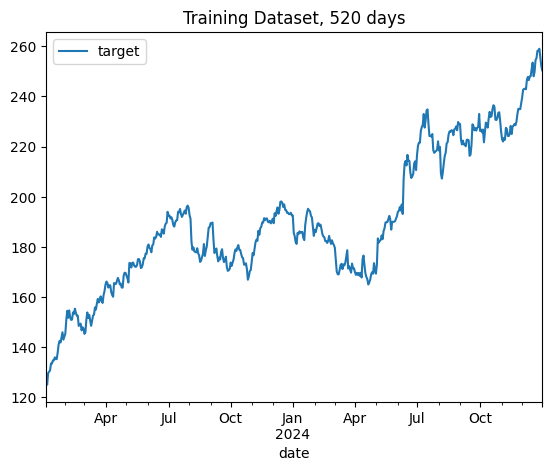

In [12]:
# Convert index to datetime
df.index = pd.to_datetime(df.index)

# Ensure 'close' column has no NaNs
df3 = df.dropna(subset=['close'])

# Ensure index is datetime and sorted
df3.index = pd.to_datetime(df3.index, errors='coerce')
df3.sort_index(inplace=True)

# Reset index and check column names
df_reset = df3.reset_index()
print(df_reset.columns)  # Check actual column names

# Rename the correct column if needed
if 'index' in df_reset.columns:
    df_reset.rename(columns={'index': 'date'}, inplace=True)
elif 'Date' in df_reset.columns:
    df_reset.rename(columns={'Date': 'date'}, inplace=True)  # Some datasets store date as 'Date'

# Melt DataFrame
df_melted = df_reset.melt(id_vars=["date"], var_name="item_id", value_name="target")

# Ensure 'date' is properly formatted
df_melted['date'] = pd.to_datetime(df_melted['date'], errors='coerce')
df_melted = df_melted.dropna(subset=['date'])
df_melted.set_index("date", inplace=True)

# Keep only 'close' prices
df_melted = df_melted[df_melted['item_id'] == 'close']

# Remove duplicate timestamps
df_melted = df_melted[~df_melted.index.duplicated(keep='first')]

# Ensure regular business day frequency
df_melted = df_melted.asfreq('B', method='pad')

# Infer frequency
freq = pd.infer_freq(df_melted.index)
if freq is None:
    freq = "B"
print(f"Frequency inferred: {freq}")

# Cut out 365*16 preceding days
# df_melted = df_melted.iloc[int(365*16 + 400):]

# Display & plot
df_melted.plot(title = f"Training Dataset, {len(df_melted)} days")
plt.show()

In [13]:
df_melted

,item_id,target
date,,
2023-01-04 00:00:00+00:00,close,126.36
2023-01-05 00:00:00+00:00,close,125.02
2023-01-06 00:00:00+00:00,close,129.62
2023-01-09 00:00:00+00:00,close,130.15
2023-01-10 00:00:00+00:00,close,130.73
...,...,...
2024-12-25 00:00:00+00:00,close,258.20
2024-12-26 00:00:00+00:00,close,259.02
2024-12-27 00:00:00+00:00,close,255.59


In [14]:
# set numerical columns as float32
for col in df_melted.columns:
    # Check if column is not of string type
    if df_melted[col].dtype != 'object' and pd.api.types.is_string_dtype(df_melted[col]) == False:
        df_melted[col] = df_melted[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df_melted, target="target", item_id="item_id")

backtest_dataset = dataset
# prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency

prediction_length = 24 # We predict just the next day?

num_samples = 550 # number of samples sampled from the probability distribution for each timestep
# device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment

# Lets go CPU
device = torch.device("cpu") 
context_length = 32

In [15]:
# not the number of training samples, but the number of time series entities (should be 1, since we are only considering price)
print(len(backtest_dataset)) 

1


In [16]:
ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only = False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]
print(estimator_args)

estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length, # how many steps it forecasts
        context_length=context_length, # how many past steps the model looks at

        # distr_output="neg_bin",
        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=5e-4,

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        time_feat=estimator_args["time_feat"],

        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
        # },

        batch_size=32,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 20,}, # <- lightning trainer arguments
    )

# num_train_windows_it_sees = D_len - context_length - prediction_length + 1 



{'input_size': 1, 'context_length': 32, 'max_context_length': 2048, 'lags_seq': [0, 7, 8, 10, 11, 12, 13, 14, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 46, 47, 48, 50, 51, 52, 55, 57, 58, 59, 60, 61, 70, 71, 72, 83, 94, 95, 96, 102, 103, 104, 117, 118, 119, 120, 121, 142, 143, 144, 154, 155, 156, 166, 167, 168, 177, 178, 179, 180, 181, 334, 335, 336, 362, 363, 364, 502, 503, 504, 670, 671, 672, 718, 719, 720, 726, 727, 728, 1090, 1091, 1092], 'n_layer': 8, 'n_embd_per_head': 16, 'n_head': 9, 'scaling': 'robust', 'distr_output': gluonts.torch.distributions.studentT.StudentTOutput(), 'num_parallel_samples': 100, 'rope_scaling': None, 'time_feat': True, 'dropout': 0.0}


In [17]:
# from gluonts.dataset.repository.datasets import get_dataset
# dataset = get_dataset("m4_weekly")
# print(dataset.train)
predictor = estimator.train(backtest_dataset, cache_data=True, shuffle_buffer_length=1000)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/lajiet/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/lajiet/anaconda3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:44: Attribute 'loss' removed from hparams because it cannot be pickled. You can suppress this warning by setting `self.save_hyperparameters(ignore=['loss'])`.
/Users/lajiet/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_vali

Training: |                                                                                                   …

Epoch 0, global step 50: 'train_loss' reached 5.01515 (best 5.01515), saving model to '/Users/lajiet/Documents/N_AdvancedPython/APDS-Project/time-series-models/lightning_logs/version_114/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3.57227 (best 3.57227), saving model to '/Users/lajiet/Documents/N_AdvancedPython/APDS-Project/time-series-models/lightning_logs/version_114/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.53511 (best 3.53511), saving model to '/Users/lajiet/Documents/N_AdvancedPython/APDS-Project/time-series-models/lightning_logs/version_114/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.07670 (best 3.07670), saving model to '/Users/lajiet/Documents/N_AdvancedPython/APDS-Project/time-series-models/lightning_logs/version_114/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 2.92567 (best 2.92567), sav

/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df = df.to_period(freq=self.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/dataset/pandas.py:174: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df = df.to_period(freq=self.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/dataset/split.py:181: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  sliced_entry[FieldName.START] += offset
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=sta

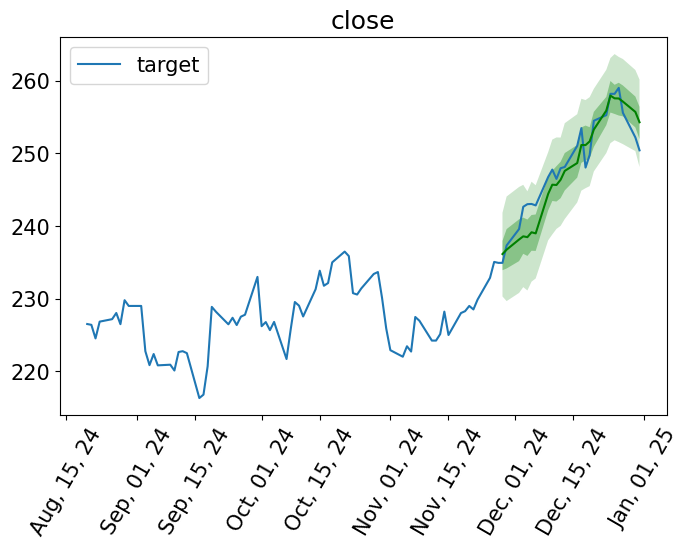

In [18]:
from tqdm import tqdm
forecast_it, ts_it = make_evaluation_predictions(
        dataset=backtest_dataset,
        predictor=predictor,
        num_samples=num_samples
    )
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d, %y')
plt.rcParams.update({'font.size': 15})

# Iterate through the first 9 series, and plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # plt.plot(ts.to_timestamp(), label="target", ) # Plots the full timeline
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g') # Plots the forecase
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

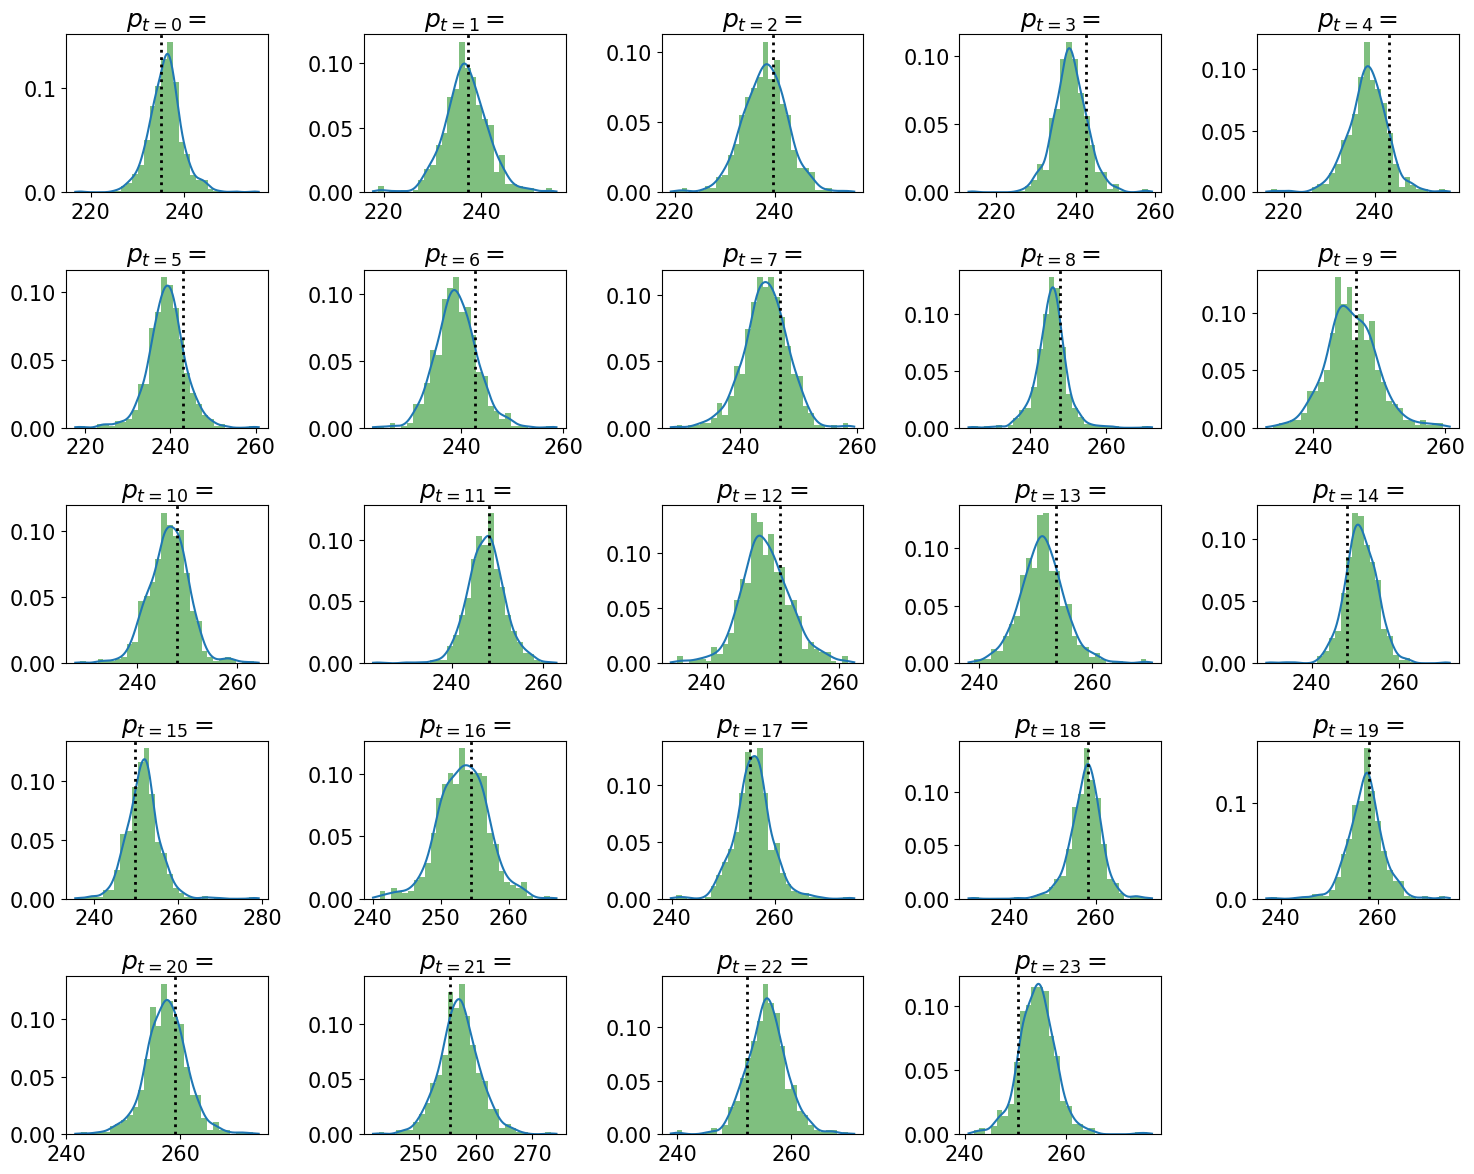

In [19]:
from scipy.stats import gaussian_kde


rows, cols = 5, 5  # Can adjust if needed
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()  

kdes = []
# Process each 24 time step 
for t in range(24):  
    ax = axes[t]  

    # Extract samples for time step t across 350 samples
    samples = forecast.samples[:, t]  # Shape: (350,)

    kde_1 = gaussian_kde(samples)
    kdes.append(kde_1)
    x_values = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
    y_values = kde_1(x_values)

    ax.plot(x_values, y_values, label="KDE")
    ax.hist(samples, bins=30, density=True, alpha=0.5, label="histogram", color='green')
    ax.axvline(x=df_melted["target"].iloc[-prediction_length + t], color='black', linestyle='dotted', linewidth=2)
    ax.set_title(r"$p_{t=" + str(t) + r"} = " + r"$")
    # ax.legend()

for i in range(t + 1, len(axes)):  
    fig.delaxes(axes[i])  # Remove unused subplots

plt.tight_layout()
plt.show()

In [20]:
kdes[:2]

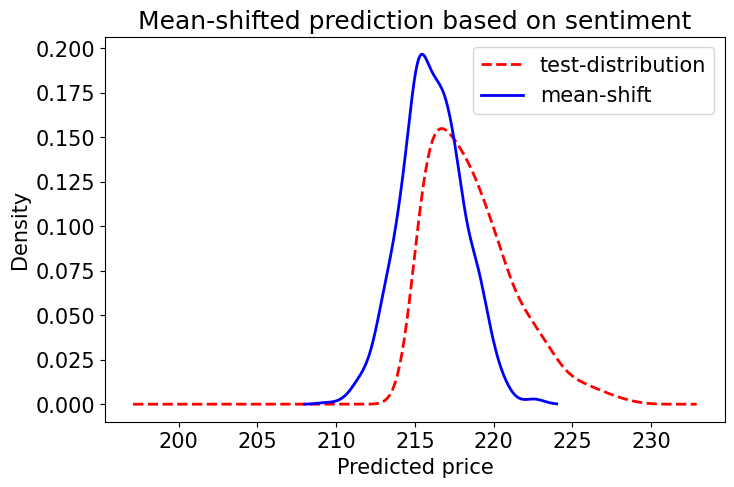

In [21]:

def how_we_feelin_today(center=0, variance=1, skewness=0, num_samples=1000, bw='scott', range_min=None, range_max=None):
    std_dev = np.sqrt(variance)  # convert variance to standard deviation

    # default range if not provided
    if range_min is None:
        range_min = center - 4 * std_dev  # 4-sigma rule for coverage
    if range_max is None:
        range_max = center + 4 * std_dev

    # base samples from a normal distribution
    base_samples = np.random.normal(loc=center, scale=std_dev, size=num_samples)

    # Apply skewness transformation if needed
    if skewness != 0:
        base_samples = stats.skewnorm.rvs(a=skewness * 5, loc=center, scale=std_dev, size=num_samples)

    # keep values within range
    base_samples = np.clip(base_samples, range_min, range_max)

    kde = stats.gaussian_kde(base_samples, bw_method=bw)

    # generate x-range for KDE evaluation
    x_range = np.linspace(range_min, range_max, 240)
    kde_values = kde(x_range)

    return x_range, kde_values, kde

def linear_mean_shift(center, sentiment, alpha=1.0, variance=1.0, num_samples=1000,
                      bw='scott', range_min=None, range_max=None):
    std_dev = np.sqrt(variance)

    # Apply mean shift
    shifted_mean = center + alpha * sentiment

    # Default plotting range
    if range_min is None:
        range_min = shifted_mean - 4 * std_dev
    if range_max is None:
        range_max = shifted_mean + 4 * std_dev

    # Sample from shifted Gaussian
    samples = np.random.normal(loc=shifted_mean, scale=std_dev, size=num_samples)
    samples = np.clip(samples, range_min, range_max)

    # Create KDE for plotting
    kde = stats.gaussian_kde(samples, bw_method=bw)
    x_range = np.linspace(range_min, range_max, 240)
    kde_values = kde(x_range)

    return x_range, kde_values, kde

x_ppd1, x_ppd1_func_values, ppdf_func1 = how_we_feelin_today(center=215, variance=20, skewness=5, num_samples=2000, bw=0.3)
x_ppd2, x_ppd2_func_values, ppdf_func2 = linear_mean_shift(center=215,
                                     sentiment=0.5,
                                     alpha=2.0,
                                     variance=4)

plt.figure(figsize=(8, 5))
plt.plot(x_ppd1, x_ppd1_func_values, color="red", linewidth=2, linestyle="dashed", label="test-distribution")
plt.xlabel("Score")
plt.ylabel("Density")
plt.title("PDF signal")



plt.plot(x_ppd2, x_ppd2_func_values, color="blue", linewidth=2, label = "mean-shift")
plt.title("Mean-shifted prediction based on sentiment")
plt.xlabel("Predicted price")
plt.ylabel("Density")

plt.legend()

plt.show()

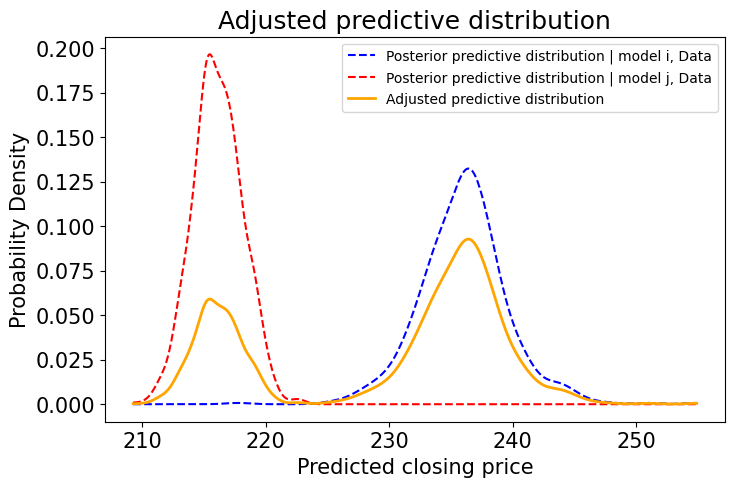

In [22]:
def bma_kde(x_range, kde_1, kde_2, w_1=0.6, w_2=0.4):
    weight_sum = w_1 + w_2
    w_1 /= weight_sum
    w_2 /= weight_sum

    # compute individual KDEs and normalize
    pdf_1 = kde_1(x_range)
    pdf_1 /= np.trapz(pdf_1, x_range)  

    pdf_2 = kde_2(x_range)
    pdf_2 /= np.trapz(pdf_2, x_range)  

    # Compute weighted sum
    bma_pdf = w_1 * pdf_1 + w_2 * pdf_2
    bma_pdf /= np.trapz(bma_pdf, x_range)  # Normalize final BMA kDE
    
    return bma_pdf

x_range_temp = np.linspace(min(min(kdes[0].dataset[0]), min(ppdf_func2.dataset[0])),
                      max(max(kdes[0].dataset[0]), max(ppdf_func2.dataset[0])),
                      500)

# Compute BMA KDE
bma_pdf_values_temp = bma_kde(x_range_temp, kdes[0], ppdf_func2, w_1=0.7, w_2=0.3)

# Plot 
plt.figure(figsize=(8, 5))

plt.plot(x_range_temp, kdes[0](x_range_temp), label="Posterior predictive distribution | model i, Data", linestyle="dashed", color="blue")
plt.plot(x_range_temp, ppdf_func2(x_range_temp), label="Posterior predictive distribution | model j, Data", linestyle="dashed", color="red")
plt.plot(x_range_temp, bma_pdf_values_temp, label="Adjusted predictive distribution", color="orange", linewidth=2)

plt.xlabel("Predicted closing price")
plt.ylabel("Probability Density")
plt.title("Adjusted predictive distribution")
plt.legend(fontsize=10)
plt.show()

/var/folders/75/q92ms1g96zg7cy3q5zmjh2100000gn/T/ipykernel_52990/3701735954.py:15: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  forecast_dates = pd.period_range(
/var/folders/75/q92ms1g96zg7cy3q5zmjh2100000gn/T/ipykernel_52990/3701735954.py:15: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  forecast_dates = pd.period_range(
/var/folders/75/q92ms1g96zg7cy3q5zmjh2100000gn/T/ipykernel_52990/3701735954.py:19: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  ).to_timestamp()


Forecast date: 2024-11-28 00:00:00+00:00 | Sentiment: 0.157
Forecast date: 2024-11-29 00:00:00+00:00 | Sentiment: 0.002
Forecast date: 2024-12-02 00:00:00+00:00 | Sentiment: -0.228
Forecast date: 2024-12-03 00:00:00+00:00 | Sentiment: -0.059
Forecast date: 2024-12-04 00:00:00+00:00 | Sentiment: 0.017
Forecast date: 2024-12-05 00:00:00+00:00 | Sentiment: 0.137
Forecast date: 2024-12-06 00:00:00+00:00 | Sentiment: -0.002
Forecast date: 2024-12-09 00:00:00+00:00 | Sentiment: 0.167
Forecast date: 2024-12-10 00:00:00+00:00 | Sentiment: 0.187
Forecast date: 2024-12-11 00:00:00+00:00 | Sentiment: 0.115
Forecast date: 2024-12-12 00:00:00+00:00 | Sentiment: 0.393
Forecast date: 2024-12-13 00:00:00+00:00 | Sentiment: -0.263
Forecast date: 2024-12-16 00:00:00+00:00 | Sentiment: -0.080
Forecast date: 2024-12-17 00:00:00+00:00 | Sentiment: -0.339
Forecast date: 2024-12-18 00:00:00+00:00 | Sentiment: -0.183
Forecast date: 2024-12-19 00:00:00+00:00 | Sentiment: 0.011
Forecast date: 2024-12-20 00:00:0

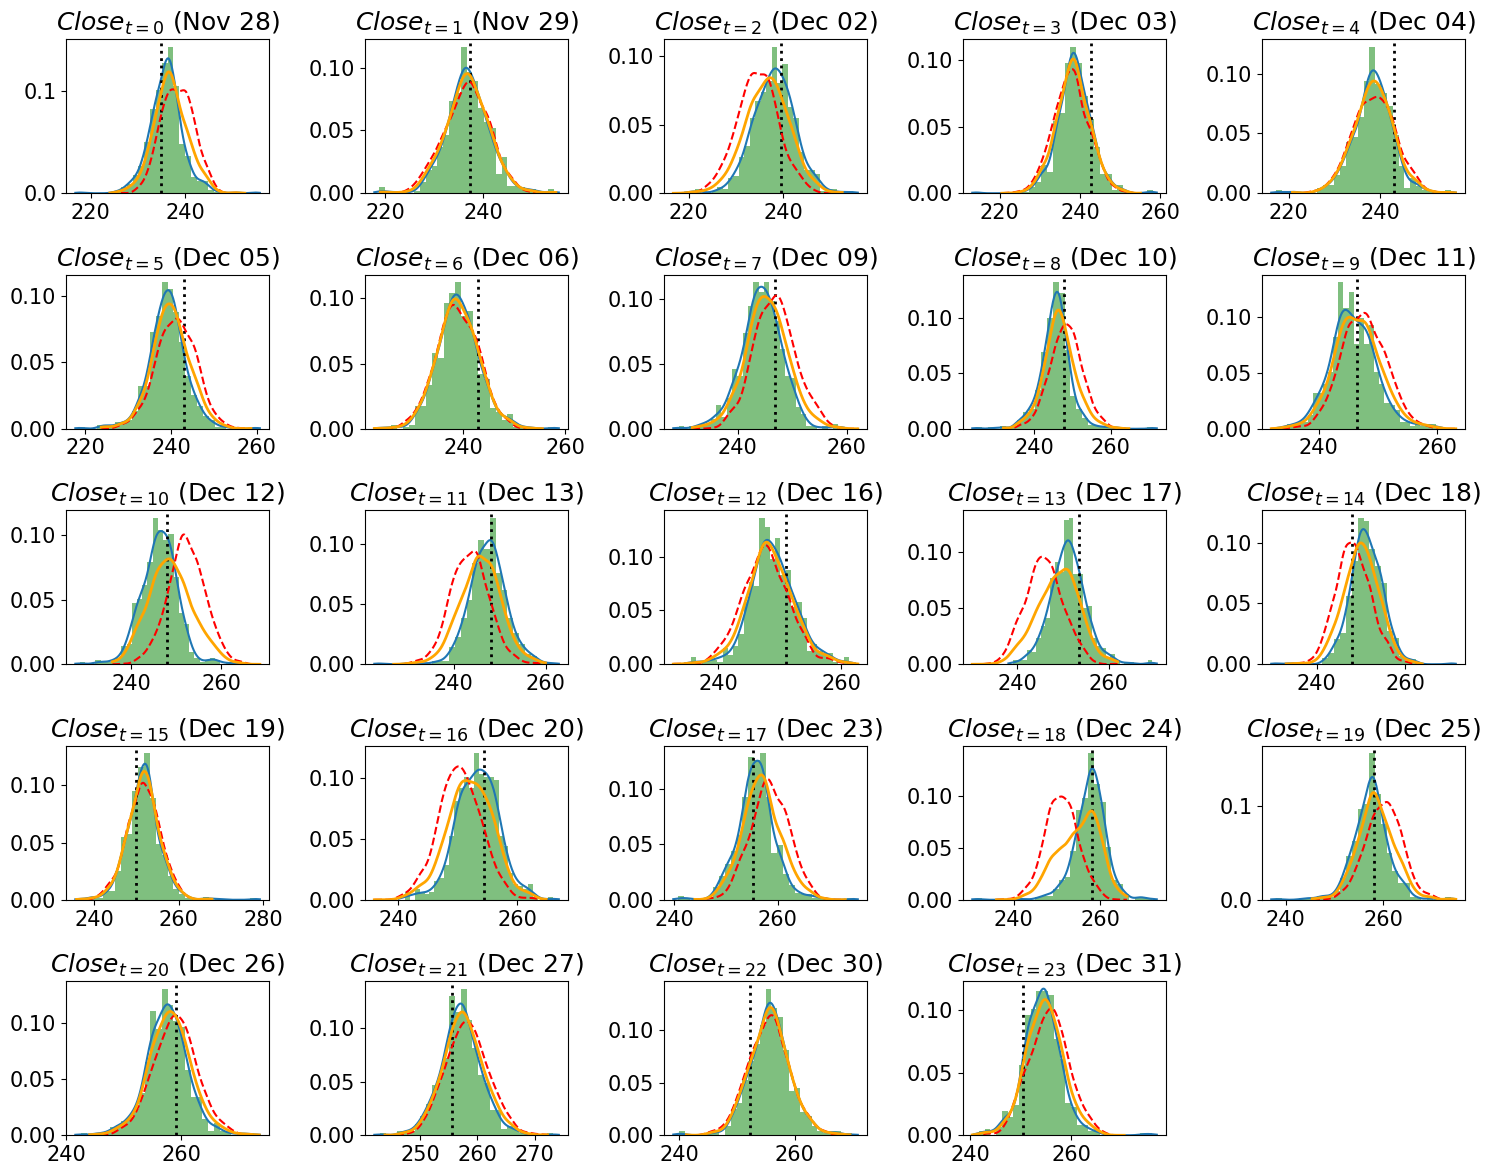

In [23]:
# ✅ Clean sentiment series setup
# df_sent_daily directly (already a Series with datetime index)
sentiment_series = df_sent_daily.copy()

# Ensure the index is timezone-aware (UTC)
if sentiment_series.index.tz is None:
    sentiment_series.index = sentiment_series.index.tz_localize('UTC')

# === Setup figure
rows, cols = 5, 5  
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
axes = axes.flatten()  

# Generate forecast dates in advance (business days)
forecast_dates = pd.period_range(
    start=forecast.start_date,
    periods=24,
    freq="B"
).to_timestamp()

# Ensure forecast_dates are timezone-aware
forecast_dates = forecast_dates.tz_localize("UTC") if forecast_dates.tz is None else forecast_dates.tz_convert("UTC")

# Initialize placeholders
kdes = []
cs = []
sks = []
vs = []

# === Loop over time steps
for t in range(24):  
    ax = axes[t]  

    samples = forecast.samples[:, t]  
    kde_1 = gaussian_kde(samples)

    x_values = np.linspace(samples.min() - 1, samples.max() + 1, 1000)
    y_values = kde_1(x_values)

    # ✅ Get forecast date (timezone-aware)
    forecast_date = forecast_dates[t]
    if forecast_date.tzinfo is None:
        forecast_date = forecast_date.tz_localize('UTC')
    else:
        forecast_date = forecast_date.tz_convert('UTC')

    # ✅ Safe lookup from sentiment_series
    sentiment = sentiment_series.get(forecast_date, 0.0)
    print(f"Forecast date: {forecast_date} | Sentiment: {sentiment:.3f}")

    # === Generate sentiment-adjusted KDE
    c = np.mean(samples)
    v = np.var(samples)
    alpha = 15.0  # tuning knob

    x_range, pdf_values, pdf_func1 = linear_mean_shift(
        center=c,
        sentiment=sentiment,
        alpha=alpha,
        variance=v
    )

    # === Combine via BMA
    bma_pdf_values = bma_kde(x_range, kde_1, pdf_func1, w_1=0.6, w_2=0.4)

    # === Plot components
    ax.plot(x_values, y_values, label="KDE")
    ax.hist(samples, bins=30, density=True, alpha=0.5, label="Histogram", color='green')
    ax.axvline(x=df_melted["target"].iloc[-prediction_length + t], color='black', linestyle='dotted', linewidth=2)
    ax.plot(x_range, pdf_func1(x_range), label="Shifted KDE", linestyle="dashed", color="red")
    ax.plot(x_range, bma_pdf_values, label="BMA KDE", color="orange", linewidth=2)

    ax.set_title(r"$Close_{t=" + str(t) + r"}$ (" + forecast_date.strftime('%b %d') + ")")
    # Optional: ax.legend()

# === Clean up unused plots
for i in range(t + 1, len(axes)):  
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=start.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/feature.py:364: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index = pd.period_range(start, periods=length, freq=start.freq)
/Users/lajiet/anaconda3/lib/python3.11/site-packages/gluonts/transform/split.py:150: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  entry[self.start_field] + idx + self.lead_time
Forecasting batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.12s/it]
/Users/lajie

Forecast date: 2024-11-28 00:00:00+00:00 | Sentiment: 0.157
Forecast date: 2024-11-29 00:00:00+00:00 | Sentiment: 0.002
Forecast date: 2024-12-02 00:00:00+00:00 | Sentiment: -0.228
Forecast date: 2024-12-03 00:00:00+00:00 | Sentiment: -0.059
Forecast date: 2024-12-04 00:00:00+00:00 | Sentiment: 0.017
Forecast date: 2024-12-05 00:00:00+00:00 | Sentiment: 0.137
Forecast date: 2024-12-06 00:00:00+00:00 | Sentiment: -0.002
Forecast date: 2024-12-09 00:00:00+00:00 | Sentiment: 0.167
Forecast date: 2024-12-10 00:00:00+00:00 | Sentiment: 0.187
Forecast date: 2024-12-11 00:00:00+00:00 | Sentiment: 0.115
Forecast date: 2024-12-12 00:00:00+00:00 | Sentiment: 0.393
Forecast date: 2024-12-13 00:00:00+00:00 | Sentiment: -0.263
Forecast date: 2024-12-16 00:00:00+00:00 | Sentiment: -0.080
Forecast date: 2024-12-17 00:00:00+00:00 | Sentiment: -0.339
Forecast date: 2024-12-18 00:00:00+00:00 | Sentiment: -0.183
Forecast date: 2024-12-19 00:00:00+00:00 | Sentiment: 0.011
Forecast date: 2024-12-20 00:00:0

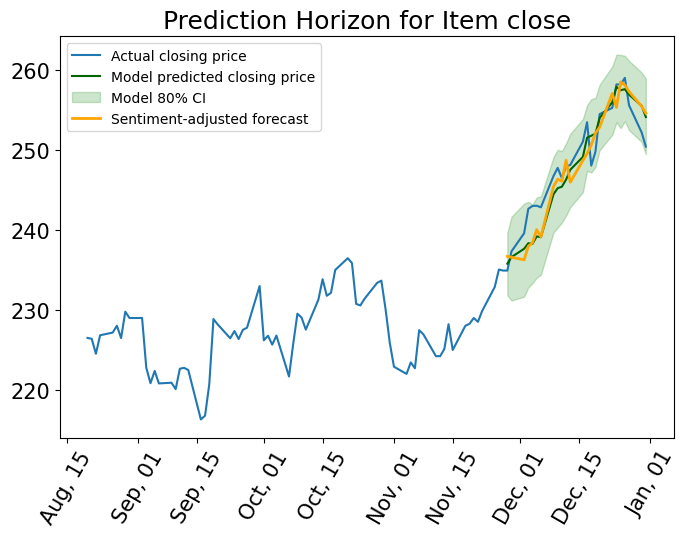


Evaluation Metrics
=== Original Model Forecast ===
MSE: 6.1214
Adjusted R²: 0.8470

=== Sentiment-adjusted BMA Forecast ===
MSE: 7.0247
Adjusted R²: 0.8244


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from scipy.stats import gaussian_kde
from itertools import islice
from sklearn.metrics import mean_squared_error, r2_score

# df_sent_daily directly (already a Series with datetime index)
sentiment_series = df_sent_daily.copy()
if sentiment_series.index.tz is None:
    sentiment_series.index = sentiment_series.index.tz_localize('UTC')

sentiment_series = sentiment_series.groupby(sentiment_series.index).mean()

def kde_mode(kde, x_range):
    return x_range[np.argmax(kde(x_range))]

def bma_pdf(x_range, pdf_1, pdf_2, w_1=0.6, w_2=0.4):
    w_1, w_2 = w_1 / (w_1 + w_2), w_2 / (w_1 + w_2)
    pdf_values_1 = pdf_1(x_range) if callable(pdf_1) else pdf_1  
    pdf_values_2 = pdf_2(x_range) if callable(pdf_2) else pdf_2
    bma_values = w_1 * pdf_values_1 + w_2 * pdf_values_2
    return bma_values / np.trapz(bma_values, x_range)

# Run forecasts
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
    num_samples=num_samples
)
forecasts = list(tqdm(forecast_it, total=len(dataset), desc="Forecasting batches"))
tss = list(tqdm(ts_it, total=len(dataset), desc="Ground truth"))

# Prepare to accumulate metrics
all_true = []
all_bma = []
all_pred = []

# Plotting config
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-4 * prediction_length:].to_timestamp(), label="Actual closing price", color='#1f77b4')

    forecast_dates = pd.period_range(
        start=forecast.start_date,
        periods=prediction_length,
        freq="B"
    ).to_timestamp()

    bma_estimates = []

    for t in range(prediction_length):
        samples = forecast.samples[:, t]
        kde_1 = gaussian_kde(samples)
        center = np.mean(samples)
        var = np.var(samples)
        std = np.sqrt(var)

        forecast_date = forecast_dates[t]
        if forecast_date.tzinfo is None:
            forecast_date = forecast_date.tz_localize('UTC')
        else:
            forecast_date = forecast_date.tz_convert('UTC')

        sentiment = sentiment_series.get(forecast_date, 0.0)
        print(f"Forecast date: {forecast_date} | Sentiment: {sentiment:.3f}")

        x_range, _, pdf_func2 = linear_mean_shift(
            center=center,
            sentiment=sentiment,
            alpha=15.0,
            variance=var,
            num_samples=2000,
            bw=0.1,
            range_min=center - 4 * std,
            range_max=center + 4 * std
        )

        bma_pdf_values = bma_pdf(x_range, kde_1, pdf_func2)
        bma_estimate = np.trapz(x_range * bma_pdf_values, x_range)
        bma_estimates.append(bma_estimate)

    # Store for metrics
    bma_estimates = np.array(bma_estimates)
    actual_values = ts[-prediction_length:].to_numpy()
    model_mean_preds = forecast.mean[:prediction_length]

    all_bma.append(bma_estimates)
    all_true.append(actual_values)
    all_pred.append(model_mean_preds)

    # === Plotting
    mean_series = pd.Series(model_mean_preds, index=forecast_dates)
    plt.plot(mean_series, color='darkgreen', label="Model predicted closing price")
    plt.fill_between(
        forecast_dates,
        forecast.quantile(0.1),
        forecast.quantile(0.9),
        color="green", alpha=0.2, label="Model 80% CI"
    )
    plt.plot(forecast_dates, bma_estimates, label="Sentiment-adjusted forecast", color="orange", linewidth=2)

    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(f"Prediction Horizon for Item {forecast.item_id}")
    ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

# === Compute Metrics ===
y_true = np.concatenate(all_true)
y_pred_model = np.concatenate(all_pred)
y_pred_bma = np.concatenate(all_bma)

# --- Original Forecast
mse_model = mean_squared_error(y_true, y_pred_model)
r2_model = r2_score(y_true, y_pred_model)
adj_r2_model = 1 - (1 - r2_model) * (len(y_true) - 1) / (len(y_true) - 1 - 1)

# --- Sentiment-adjusted Forecast
mse_bma = mean_squared_error(y_true, y_pred_bma)
r2_bma = r2_score(y_true, y_pred_bma)
adj_r2_bma = 1 - (1 - r2_bma) * (len(y_true) - 1) / (len(y_true) - 1 - 1)

print("\nEvaluation Metrics")
print("=== Original Model Forecast ===")
print(f"MSE: {mse_model:.4f}")
print(f"Adjusted R²: {adj_r2_model:.4f}")

print("\n=== Sentiment-adjusted BMA Forecast ===")
print(f"MSE: {mse_bma:.4f}")
print(f"Adjusted R²: {adj_r2_bma:.4f}")
